## Pipeline Building for Random Forest and GradientBoosting algorithms

### Approach:<br>
Selecting bivariate model based on higher precision of Operating class<br>

Building multivariate model based on the records that bivariate model was not able to predict as Operating class<br>

Selecting multivariate model based on higher accuracy<br>

Combining the predictions of both models and calculating final accuracy.<br>

### Import required libraries

In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in cast")
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.optimize.linesearch")
warnings.filterwarnings('ignore')


In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import Classification Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error , confusion_matrix , classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split ,GridSearchCV

# Import Feature Engineering Techniques
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest , chi2, mutual_info_regression

# Import Classification Models
from sklearn.linear_model import  Lasso , Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

# Import the matplotlib and seaborn libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
import seaborn as sns
sns.set()
import plotly
import plotly.express as px

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from xgboost import XGBClassifier

In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn import set_config
import pickle


### Create Function to traina, test and evaluate

In [4]:
target_names_bin = [ 'Operating','Closed']
target_names_mul = [ 'Operating','IPO','Acquired','Closed']

def model_accuracy(actual, predicted):
    confusion_mat = confusion_matrix(actual, predicted)
    class_report = classification_report(actual, predicted,  target_names= target_names_bin )

    print(f"accuracy: {round(accuracy_score(actual, predicted),2)}")
    print(f"precision: {round(precision_score(actual, predicted),2)}")
    print(f"recall/sensitivity: {round(recall_score(actual, predicted),2)}")
    print(class_report)
    print(confusion_mat)
    # Plot Confusion Matrix
    sns.heatmap(confusion_mat,annot=True, fmt='d', annot_kws={'fontsize': 20})
    plt.show()

def multiclass_model_accuracy(part, actual, predicted):
    accuracy = accuracy_score(actual, predicted)
    confusion_mat = confusion_matrix(actual, predicted)
    class_report = classification_report(actual, predicted,  target_names= target_names_mul)
    precision = precision_score(actual, predicted, average="macro")
    recall = recall_score(actual, predicted,average="macro")
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    print(f"{part}_accuracy: {round(accuracy,2)}")
    print(f"{part}_precision: {round(precision,2)}")
    print(f"{part}_recall/sensitivity: {round(recall,2)}")
    print(f"\nMean Absolute Error: {round(mae,2)}")
    print(f"Root Mean Squared Error: {round(rmse,2)}")
    print(f"Confusion Matrix of {part} data")
    print(confusion_mat)
    # Plot Confusion Matrix
    sns.heatmap(confusion_mat,annot=True, fmt='d', annot_kws={'fontsize': 20})
    plt.show()

from google.colab import drive
drive.mount('/content/drive')

### Load Clean Dataset

In [5]:
dataset = pd.read_csv('data/clean_data.csv')
df = dataset.copy()
df.head(5)

,category_code,status,founded_at,country_code,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,lat,lng,active_days
0,web,acquired,2007,USA,2008,2008,1,5000000.0,2008,2012,3,14,37.386052,-122.083851,4015.0
1,enterprise,operating,2004,USA,2011,2011,1,1500000.0,2010,2010,1,8,47.610150,-122.201516,6205.0
2,web,operating,2006,USA,2007,2007,1,2500000.0,2010,2012,2,7,37.774929,-122.419415,5475.0
3,ecommerce,operating,2004,USA,2011,2011,1,3800000.0,2012,2012,1,9,47.610150,-122.201516,6205.0
4,games_video,operating,2011,USA,2011,2011,1,40000.0,2012,2012,1,5,37.774929,-122.419415,3650.0


### Encode for categorical columns

In [6]:
dummies_country=pd.get_dummies(df['country_code'], dtype=int, prefix='country_code')
df=pd.concat((df, dummies_country), axis=1)
df.drop('country_code', axis=1, inplace=True)

dummies_category=pd.get_dummies(df['category_code'], dtype=int, prefix='category_code')
df=pd.concat((df, dummies_category), axis=1)
df.drop('category_code', axis=1, inplace=True)
df.head()

,status,founded_at,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,lat,lng,active_days,country_code_AUS,country_code_CAN,country_code_DEU,country_code_ESP,country_code_FRA,country_code_GBR,country_code_IND,country_code_ISR,country_code_USA,country_code_other,category_code_advertising,category_code_analytics,category_code_biotech,category_code_cleantech,category_code_ecommerce,category_code_education,category_code_enterprise,category_code_finance,category_code_games_video,category_code_hardware,category_code_mobile,category_code_network_hosting,category_code_other,category_code_social,category_code_software,category_code_web
0,acquired,2007,2008,2008,1,5000000.0,2008,2012,3,14,37.386052,-122.083851,4015.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,operating,2004,2011,2011,1,1500000.0,2010,2010,1,8,47.610150,-122.201516,6205.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,operating,2006,2007,2007,1,2500000.0,2010,2012,2,7,37.774929,-122.419415,5475.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,operating,2004,2011,2011,1,3800000.0,2012,2012,1,9,47.610150,-122.201516,6205.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,operating,2011,2011,2011,1,40000.0,2012,2012,1,5,37.774929,-122.419415,3650.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Remove duplicates and Null values

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [8]:
df.isna().sum()

status                           0
founded_at                       0
first_funding_at                 0
last_funding_at                  0
funding_rounds                   0
funding_total_usd                0
first_milestone_at               0
last_milestone_at                0
milestones                       0
relationships                    0
lat                              0
lng                              0
active_days                      0
country_code_AUS                 0
country_code_CAN                 0
country_code_DEU                 0
country_code_ESP                 0
country_code_FRA                 0
country_code_GBR                 0
country_code_IND                 0
country_code_ISR                 0
country_code_USA                 0
country_code_other               0
category_code_advertising        0
category_code_analytics          0
category_code_biotech            0
category_code_cleantech          0
category_code_ecommerce          0
category_code_educat

### Convert target variable to discrete values

In [9]:
df['status'].value_counts()

operating    7674
acquired      978
closed        117
ipo            61
Name: status, dtype: int64

In [10]:
df['status_class']=df['status']
df['status_class']=df['status_class'].replace({'operating':0,'ipo':1,'closed':3,'acquired':2})
df['status']=df['status'].replace({'operating':0,'ipo':0,'closed':1,'acquired':1})

In [11]:
df['status'].value_counts()

0    7735
1    1095
Name: status, dtype: int64

In [12]:
df['status_class'].value_counts()

0    7674
2     978
3     117
1      61
Name: status_class, dtype: int64

### Split data into Input and Targets

In [13]:
inputs = df.drop(['status','status_class'], axis=1)
target = df['status']
target_multi = df['status_class']

### Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(inputs, target)

In [15]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Binary Target Class Pipeline

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    #('feature_selector', SelectKBest(score_func=mutual_info_classif, k=20)),
    ('model', RandomForestClassifier())
    ])

In [18]:
#set_config(display="diagram")
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', RandomForestClassifier())])

### Call the previously built function to train and evaluate model

In [19]:
Operating_prob = pipeline.predict_proba(X_train)[:,1]
RF_training_result = pd.DataFrame()
RF_training_result["Operating_prob"] = Operating_prob
RF_training_result['predicted'] = RF_training_result.Operating_prob.map( lambda x: 1 if x > 0.5 else 0)
RF_training_result['actual'] = y_train
RF_training_result.head(5)

,Operating_prob,predicted,actual
0,0.00,0,0
1,0.00,0,0
2,0.01,0,0
3,0.00,0,0
4,1.00,1,1


In [20]:
RF_training_result.isna().sum()

Operating_prob    0
predicted         0
actual            0
dtype: int64

accuracy: 1.0
precision: 1.0
recall/sensitivity: 1.0
              precision    recall  f1-score   support

   Operating       1.00      1.00      1.00      5787
      Closed       1.00      1.00      1.00       835

    accuracy                           1.00      6622
   macro avg       1.00      1.00      1.00      6622
weighted avg       1.00      1.00      1.00      6622

[[5787    0]
 [   0  835]]


<IPython.core.display.Javascript object>


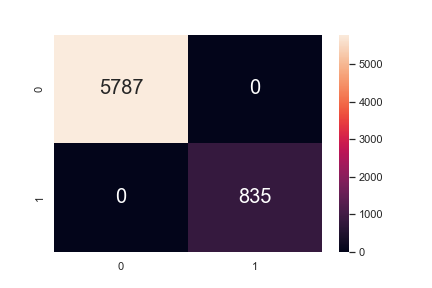

In [33]:
model_accuracy(RF_training_result['actual'] , RF_training_result['predicted'])

### Making predictions on the test set

In [22]:
Operating_prob = pipeline.predict_proba(X_test)[:,1]
RF_testing_result = pd.DataFrame()
RF_testing_result["Operating_prob"] = Operating_prob
RF_testing_result['predicted'] = RF_testing_result.Operating_prob.map( lambda x: 1 if x > 0.5 else 0)
RF_testing_result['actual'] = y_test
RF_testing_result.head()

,Operating_prob,predicted,actual
0,0.00,0,0
1,0.02,0,0
2,0.00,0,0
3,0.09,0,0
4,0.08,0,0


In [23]:
model_accuracy(RF_testing_result['actual'] , RF_testing_result['predicted'])

accuracy: 0.97
precision: 0.92
recall/sensitivity: 0.83
              precision    recall  f1-score   support

   Operating       0.98      0.99      0.98      1948
      Closed       0.92      0.83      0.88       260

    accuracy                           0.97      2208
   macro avg       0.95      0.91      0.93      2208
weighted avg       0.97      0.97      0.97      2208

[[1929   19]
 [  43  217]]


## Multi Target Class Pipeline

### Train test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(inputs, target_multi)

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
#params = { 'n_estimators' : [100], 'learning_rate' : [ 0.05], 'min_child_weight': [1],
#          'gamma': [0.5], 'subsample': [1.0],'colsample_bytree': [0.8], 'max_depth': [ 5] }
params=params = {'n_estimators': [50, 100],
                 'learning_rate': [0.01, 0.1, 0.2]}
folds = 10
model=GradientBoostingClassifier()

In [27]:
pipeline_2 = Pipeline([
    ('scaler', MinMaxScaler()),
    #('feature_selector', SelectKBest(score_func=mutual_info_classif, k=20)),
    ('model', RandomizedSearchCV(model, param_distributions=params, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42))
    ])

In [28]:
y_train.value_counts()

0    5772
2     722
3      82
1      46
Name: status_class, dtype: int64

In [29]:
pipeline_2.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 RandomizedSearchCV(cv=5,
                                    estimator=GradientBoostingClassifier(),
                                    n_jobs=-1,
                                    param_distributions={'learning_rate': [0.01,
                                                                           0.1,
                                                                           0.2],
                                                         'n_estimators': [50,
                                                                          100]},
                                    random_state=42, scoring='accuracy',
                                    verbose=3))])

### Call the previously built function to train and evaluate model

In [30]:
y_train_pred = pipeline_2.predict(X_train)
multiclass_model_accuracy( "train",y_train, y_train_pred)

train_accuracy: 0.99
train_precision: 0.99
train_recall/sensitivity: 0.98

Mean Absolute Error: 0.02
Root Mean Squared Error: 0.18
Confusion Matrix of train data
[[5770    0    2    0]
 [   0   46    0    0]
 [  50    0  670    2]
 [   0    0    2   80]]


In [31]:
y_test_pred = pipeline_2.predict(X_test)
multiclass_model_accuracy( "test",y_test, y_test_pred)

test_accuracy: 0.98
test_precision: 0.88
test_recall/sensitivity: 0.81

Mean Absolute Error: 0.03
Root Mean Squared Error: 0.23
Confusion Matrix of test data
[[1901    1    0    0]
 [   0    8    7    0]
 [  23    4  229    0]
 [   1    1    4   29]]


### Serialize the pipeline for building streamlit based application to predict the acquisition status

In [32]:
pickle.dump(pipeline, open('StartUp_Prediction_App/resourses/Model/RF_for_bivariate.pkl', 'wb'))
pickle.dump(pipeline_2, open('StartUp_Prediction_App/resourses/Model/GB_for_mulivariate.pkl', 'wb'))